In [390]:
import os
import nbimporter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from DataParserforCNN import read_class
import hull
import cv2
from DeformImage import *
                

%matplotlib inline

In [232]:
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time).astype(np.int32)
    
    coords = [[] for i in range(time.max()+1)]
    
    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            coords[t].append((x0, y0))
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
        coords[t].append((x1, y1))

    return image, coords

In [5]:
class_array = read_class()

In [10]:
base_path = '/Volumes/JS/QuickDraw/train_simplified/'

In [11]:
airplane = pd.read_csv(base_path + 'airplane.csv', nrows=1000)

In [170]:
img_for_aug = []
for i in range(12):
    img_for_aug.append(drawing_to_image(eval(airplane['drawing'][i]), H=64, W=64))

In [171]:
def draw_a_batch(batch_size=16):
    fig, m_axs = plt.subplots(3, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = img_for_aug[i] / 255.
        ax.imshow(img.astype('float'))
#         ax.set_title(CLASS_NAME[np.squeeze(np.where(trainset[0][1][0] == 1))])

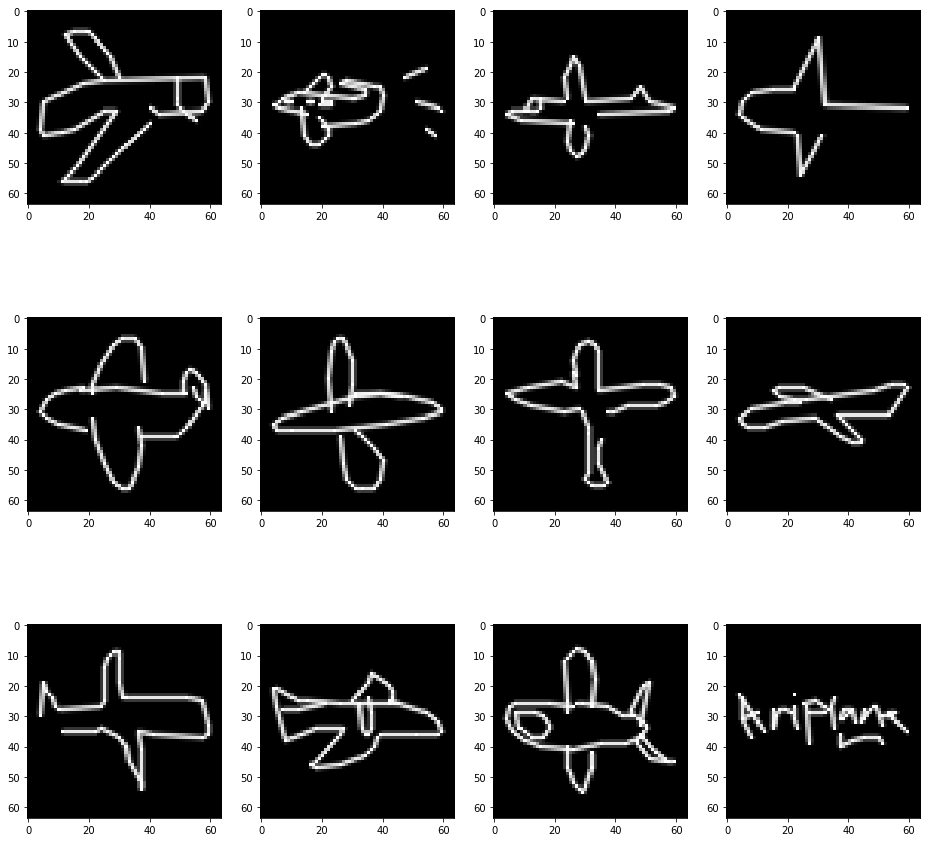

In [172]:
draw_a_batch()

In [49]:
x = np.random.rand(135) > 0.45

In [51]:
flip = np.fliplr(img_for_aug[0])

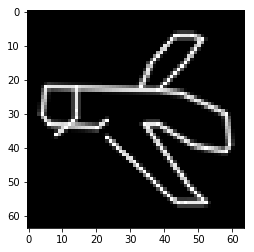

In [54]:
plt.imshow(flip.astype('uint8'))

In [59]:
batch_size = 10
degs = (np.random.rand(batch_size) > 0.45) * (np.random.randint(11, size=batch_size) - 5.0)

In [60]:
degs

array([-2.,  0., -0., -5., -2., -3., -0., -2.,  0.,  1.])

In [61]:
(np.random.rand(batch_size) > 0.45)

array([ True, False,  True, False, False,  True,  True, False,  True,
        True])

In [66]:
a = (np.random.randint(11, size=batch_size) - 5.0)
print(a)
degs = (np.random.rand(batch_size) > 0.45) * a
print(degs)

[ 5.  4. -3. -2.  2.  5.  5.  1. -3. -1.]
[ 5.  0. -3. -0.  2.  0.  5.  1. -0. -1.]


In [77]:
rot = rotate(img_for_aug[0], 5, cval=0, reshape=False)

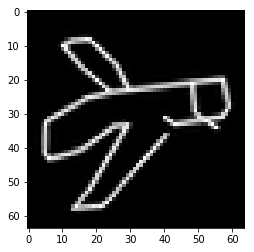

In [78]:
plt.imshow(rot.astype('uint8'))

In [227]:
ex_strokes = eval(airplane['drawing'][0])

point = []
time = []
for t,(x,y) in enumerate(ex_strokes):
#     print(t, x,y)
    point.append(np.array((x,y),np.float32).T)
    time.append(np.full(len(x),t))
time= np.concatenate(time).astype(np.int32)
print(time.max())

2


In [181]:
alpha, beta = 0.5, 0.5
pi = []
for idx, stroke in enumerate(ex_strokes):
    assert len(stroke[0]) == len(stroke[1])
    pi.append(np.exp(alpha * idx) / np.exp(beta * len(stroke[0])))
print(pi)
pi /= sum(pi)
index_to_remove = np.argsort(pi)
print(-np.sort(-index_to_remove))

[2.7536449349747158e-05, 0.1353352832366127, 0.049787068367863944]
<built-in method sort of numpy.ndarray object at 0x1355a9030>
[2 1 0]


## Global Deformation

In [199]:
point = []
for idx, (x,y) in enumerate(ex_strokes):
    point.append(np.array((x,y),np.float32).T)
point = np.concatenate(point).astype(np.float32)

[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, 30, 6, 1, 2, 66, 98, 253, 254, 246, 182, 165] [140, 194, 227, 232, 229, 229, 206, 124, 123, 149, 157, 159, 153, 110, 82, 77, 74, 109, 121, 127, 120]
[207, 207, 210, 221, 238] [74, 103, 114, 128, 135]
[119, 107, 76, 70, 49, 39, 60, 93] [72, 41, 3, 0, 1, 5, 38, 70]
[[167. 140.]
 [109. 194.]
 [ 80. 227.]
 [ 69. 232.]
 [ 58. 229.]
 [ 31. 229.]
 [ 57. 206.]
 [117. 124.]
 [ 99. 123.]
 [ 52. 149.]
 [ 30. 157.]
 [  6. 159.]
 [  1. 153.]
 [  2. 110.]
 [ 66.  82.]
 [ 98.  77.]
 [253.  74.]
 [254. 109.]
 [246. 121.]
 [182. 127.]
 [165. 120.]]


In [273]:
img, coords = drawing_to_image(ex_strokes, H=64, W=64)

In [274]:
coords

[[(40, 37),
  (28, 48),
  (21, 55),
  (19, 56),
  (17, 56),
  (11, 56),
  (16, 51),
  (29, 33),
  (25, 33),
  (15, 39),
  (11, 40),
  (5, 41),
  (4, 39),
  (5, 30),
  (18, 24),
  (25, 23),
  (58, 22),
  (59, 30),
  (57, 33),
  (43, 34),
  (40, 32)],
 [(49, 22), (49, 29), (49, 31), (52, 34), (55, 36)],
 [(30, 22), (27, 15), (20, 7), (19, 7), (15, 7), (12, 8), (17, 15), (24, 22)]]

In [209]:
x, y = np.array(coords).T

In [210]:
x

array([40, 28, 21, 19, 17, 11, 16, 29, 25, 15, 11,  5,  4,  5, 18, 25, 58,
       59, 57, 43, 40, 49, 49, 49, 52, 55, 30, 27, 20, 19, 15, 12, 17, 24],
      dtype=int32)

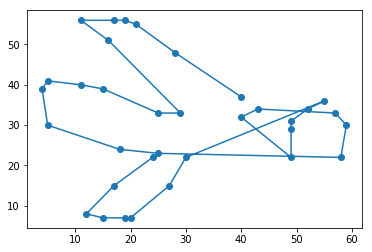

In [214]:
plt.scatter(x, y)
plt.plot(x,y)

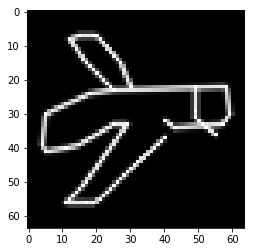

In [213]:
plt.imshow(img.astype('uint8'))

In [300]:
# print(coords[0])
temp = []
for i in range(len(coords)):
    temp.extend(coords[i])
print(temp)
convex_hull = hull.convex(temp)

[(40, 37), (28, 48), (21, 55), (19, 56), (17, 56), (11, 56), (16, 51), (29, 33), (25, 33), (15, 39), (11, 40), (5, 41), (4, 39), (5, 30), (18, 24), (25, 23), (58, 22), (59, 30), (57, 33), (43, 34), (40, 32), (49, 22), (49, 29), (49, 31), (52, 34), (55, 36), (30, 22), (27, 15), (20, 7), (19, 7), (15, 7), (12, 8), (17, 15), (24, 22)]


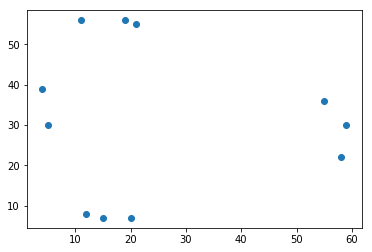

In [301]:
xx, yy = np.array(convex_hull).T
plt.scatter(xx, yy)

[40 28 21 19 17 11 16 29 25 15 11  5  4  5 18 25 58 59 57 43 40] [37 48 55 56 56 56 51 33 33 39 40 41 39 30 24 23 22 30 33 34 32]
[49 49 49 52 55] [22 29 31 34 36]
[30 27 20 19 15 12 17 24] [22 15  7  7  7  8 15 22]


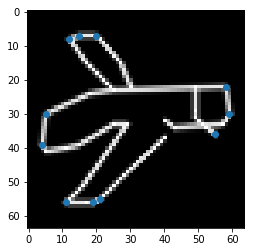

In [302]:
image = np.full((64,64,3),0,np.uint8)
for t in range(3):
    p = np.array(coords[t])
    x,y = p.T
    print(x,y)
    image[y,x]=255
    N = len(p)
    for i in range(N-1):
        x0,y0 = p[i]
        x1,y1 = p[i+1]
        cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
plt.imshow(image.astype('uint8'))
plt.scatter(xx, yy)

In [316]:
print(xx)
print(yy)
x_order = np.argsort(xx)
y_order = np.argsort(yy)
global_points = [x_order[0], x_order[-1], y_order[0], y_order[-1]]
print(global_points)

[ 4  5 12 15 20 58 59 55 21 19 11]
[39 30  8  7  7 22 30 36 55 56 56]
[0, 6, 3, 10]


In [321]:
out = []
for i in global_points:
    out.append((xx[i], yy[i]))
    print(out)
out_x, out_y = np.array(out).T
print(out_x, out_y)

[(4, 39)]
[(4, 39), (59, 30)]
[(4, 39), (59, 30), (15, 7)]
[(4, 39), (59, 30), (15, 7), (11, 56)]
[ 4 59 15 11] [39 30  7 56]


[40 28 21 19 17 11 16 29 25 15 11  5  4  5 18 25 58 59 57 43 40] [37 48 55 56 56 56 51 33 33 39 40 41 39 30 24 23 22 30 33 34 32]
[49 49 49 52 55] [22 29 31 34 36]
[30 27 20 19 15 12 17 24] [22 15  7  7  7  8 15 22]


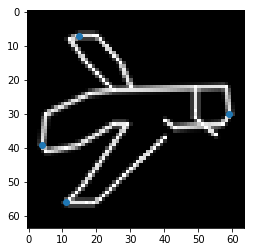

In [322]:
image = np.full((64,64,3),0,np.uint8)
for t in range(3):
    p = np.array(coords[t])
    x,y = p.T
    print(x,y)
    image[y,x]=255
    N = len(p)
    for i in range(N-1):
        x0,y0 = p[i]
        x1,y1 = p[i+1]
        cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
plt.imshow(image.astype('uint8'))
plt.scatter(out_x, out_y)

In [346]:
mu = 0 
sigma=5
noise_x = np.random.normal(mu, sigma, 4)
noise_y = np.random.normal(mu, sigma, 4)

In [347]:
print(noise_x)
print(noise_y)

[ 6.03289514 -0.94309229 10.42524564 14.64909881]
[-0.91469513 -2.183546    0.16400424  2.75232268]


In [354]:
x_with_noise = out_x + noise_x
y_with_noise = out_y + noise_y
x_with_noise = [int(min(max(0, x), 64)) for x in x_with_noise]
y_with_noise = [int(min(max(0, y), 64)) for y in y_with_noise]
print(x_with_noise)
print(y_with_noise)

[10, 58, 25, 25]
[38, 27, 7, 58]


[40 28 21 19 17 11 16 29 25 15 11  5  4  5 18 25 58 59 57 43 40] [37 48 55 56 56 56 51 33 33 39 40 41 39 30 24 23 22 30 33 34 32]
[49 49 49 52 55] [22 29 31 34 36]
[30 27 20 19 15 12 17 24] [22 15  7  7  7  8 15 22]
max  255


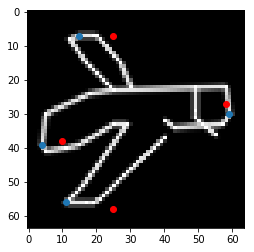

In [379]:
image = np.full((64,64,3),0,np.uint8)
for t in range(3):
    p = np.array(coords[t])
    x,y = p.T
    print(x,y)
    image[y,x]=255
    N = len(p)
    for i in range(N-1):
        x0,y0 = p[i]
        x1,y1 = p[i+1]
        cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)
plt.imshow(image.astype('uint8'))
print('max ', image.max())
plt.scatter(out_x, out_y)
plt.scatter(x_with_noise, y_with_noise, color='r')

In [384]:
p = np.array(list(zip(out_x, out_y)))
q = np.array(list(zip(x_with_noise, y_with_noise)))
print(p)
print(q)

[[ 4 39]
 [59 30]
 [15  7]
 [11 56]]
[[10 38]
 [58 27]
 [25  7]
 [25 58]]


In [421]:
new_img = mls_rigid_deformation_inv(image, p, q)
print(type(new_img))
print(new_img.max())

<class 'numpy.ndarray'>
0.9999999999999994


DeformImage.ipynb:516: RuntimeWarning: divide by zero encountered in true_divide
  "    gcol = vx.shape[1]  # grid cols\n",


254


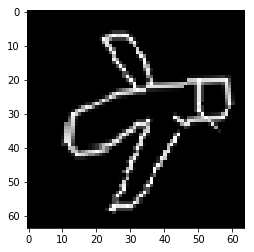

In [422]:
new_img = new_img * 255
new_img = new_img.astype('uint8')
print(new_img.max())
plt.imshow(new_img.astype('uint8'))

In [405]:
new_img_2 = mls_affine_deformation_inv(image, p, q)
print(new_img_2.max())

1.0


DeformImage.ipynb:180: RuntimeWarning: divide by zero encountered in true_divide
  "    gcol = vx.shape[1]  # grid cols\n",


In [403]:
from DeformImage import *

new_img_3 = mls_rigid_deformation(image, p, q, alpha=1.0, density=1.0)
print(new_img_3.max())

255


DeformImage.ipynb:440: RuntimeWarning: divide by zero encountered in true_divide
  "    grow = vx.shape[0]  # grid rows\n",
DeformImage.ipynb:442: RuntimeWarning: invalid value encountered in true_divide
  "    ctrls = p.shape[0]  # control points\n",
DeformImage.ipynb:462: RuntimeWarning: invalid value encountered in true_divide
  "    reshaped_neg_vpstar_verti = neg_vpstar_verti.reshape(2, 1, grow, gcol)              # [2, 1, grow, gcol]\n",
DeformImage.ipynb:474: RuntimeWarning: invalid value encountered in less
  "    # Get final image transfomer -- 3-D array\n",
DeformImage.ipynb:475: RuntimeWarning: invalid value encountered in greater
  "    temp = np.sum(np.matmul(reshaped_qhat, A), axis=0).transpose(2, 3, 0, 1)            # [1, 2, grow, gcol]\n",
DeformImage.ipynb:476: RuntimeWarning: invalid value encountered in greater
  "    reshaped_temp = temp.reshape(2, grow, gcol)                                         # [2, grow, gcol]\n",


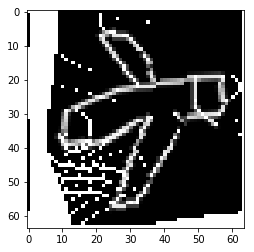

In [404]:
plt.imshow(new_img_3.astype('uint8'))